# CIFAR CLASSIFICATION

### Imports

We install tensorflow-addons to give an example of a user defined augmentation function that rotates the image to augment.

In [12]:
!pip install tensorflow-addons

In [13]:
import tensorflow as tf
import tensorflow_addons as tfa

import deel.lipdp.layers as DP_layers
import deel.lipdp.losses as DP_losses
from deel.lipdp.pipeline import bound_clip_value
from deel.lipdp.pipeline import load_and_prepare_data
from deel.lipdp.sensitivity import get_max_epochs
from deel.lipdp.model import DP_Accountant
from deel.lipdp.model import DP_Sequential
from deel.lipdp.model import DPParameters
from deel.lipdp.model import AdaptiveLossGradientClipping
from functools import partial

### Loading the data :

It is important to import the data with the right DP parameters to account properly for the privacy guarantees of the trained model. You can define augmentations with popular TensorFlow functions and the partial module from functools. Indeed, the given callables need to return an image output from an image input. Therefore, we use the partial module to create a callable that only has an image argument.

In [14]:
augment = True 

# define new augmentation to apply on dataset
def img_rotation(img, angle_max):
    value_angle = angle_max * tf.random.uniform(shape=[], dtype=tf.dtypes.float32)
    return tfa.image.rotate(img, value_angle)

rotation = partial(img_rotation, angle_max=0.8)

if augment : 
    augmentations = [
        tf.image.flip_left_right,
        rotation,
    ]
else : 
    augmentations = None 
    
# load the dataset    
ds_train, ds_test, dataset_metadata = load_and_prepare_data(
    "cifar10",
    batch_size=2048,
    colorspace="HSV",
    augmentations=augmentations,
    drop_remainder=True,  # accounting assumes fixed batch size
    bound_fct=bound_clip_value(
        15.0
    ),  # clipping preprocessing allows to control input bound
)

### Visualising the augmentations : 

All the augmented versions of the samples are stored in the same batch as the original image. This allows for correct DP leakage accounting. 

In [15]:
import matplotlib.pyplot as plt

def plot_imgs(img1,img2, title=None):
  plt.figure()
  plt.subplot(121)
  plt.imshow(tf.image.hsv_to_rgb(img1))
  plt.title("Original")
  plt.subplot(122)
  plt.imshow(tf.image.hsv_to_rgb(img2))
  plt.title(title)

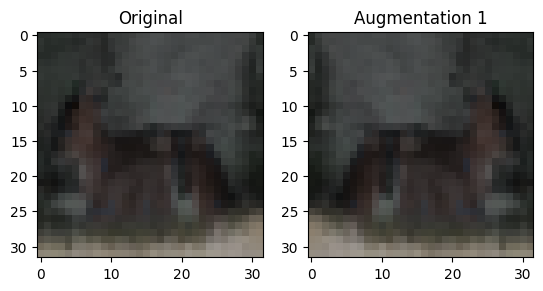

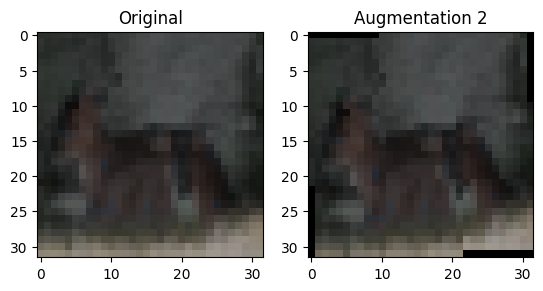

In [16]:
iterator = iter(ds_train)
imgs,labels = iterator.get_next()
N_image = 0
plot_imgs(imgs[N_image],imgs[N_image+1], title="Augmentation 1")
plot_imgs(imgs[N_image],imgs[N_image+2], title="Augmentation 2")

In [17]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(6144, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(6144, 10), dtype=tf.float32, name=None))>

### IMPORTANT REMARK :

Please pay attention to the fact that the effective batch size in memory will be batch_size $\times$ len(augmentations).

Fortunately, the backpropagation's computation time on our framework is less sensitive to the batch size than for other frameworks : 

<img src="ressources/all_speed_curves.png" alt="Speed curves with concurrent frameworks" width="800"/>

### Declaring the DP parameters :

We also need to declare explicitly the parameters of the DP training process.

In [18]:
dp_parameters = DPParameters(
    noisify_strategy="global",
    noise_multiplier=1.0,
    delta=1e-5,
)

### Defining the model :

We use a simple convolutive network to classify on the MNIST dataset. We add a loss gradient clipping layer at the end of our network for more tightness on our gradient's upper bound. Therefore allowing for better results with one less hyperparameter to tune for dynamically chosen clipping constant. Also, as introduced in De et al. (2022). Averaging the gradient of multiple augmentations of the same sample before applying the gradient step proves beneficial and allows for faster convergence than classical data augmentations.

For classical data augmentation define group_size = 1 on the clipping layer. This is the default setting.

To use the averaged loss of individually augmented samples define group_size equal to the number of augmentations plus the original images (i.e len(augmentations)+1 )

In [19]:
if augment : 
    # define the number of identical images in the batch :
    # 1 original image and it's N augmentations
    group_size = len(augmentations) + 1
else : 
    # default value
    group_size = 1

layers = [
    DP_layers.DP_BoundedInput(
        input_shape=dataset_metadata.input_shape,
        upper_bound=dataset_metadata.max_norm,
    ),
    DP_layers.DP_SpectralConv2D(
        filters=32, kernel_size=3, use_bias=False, kernel_initializer="orthogonal"
    ),
    DP_layers.DP_Flatten(),
    DP_layers.DP_SpectralDense(
        units=512, use_bias=False, kernel_initializer="orthogonal"
    ),
    DP_layers.DP_GroupSort(2),
    DP_layers.DP_SpectralDense(
        units=10, use_bias=False, kernel_initializer="orthogonal"
    ),
    DP_layers.DP_ClipGradient(
        epsilon=1, mode="dynamic_svt", patience=5, group_size=group_size,
    )
]

model = DP_Sequential(
    layers=layers, dp_parameters=dp_parameters, dataset_metadata=dataset_metadata
)

loss = DP_losses.DP_TauCategoricalCrossentropy(tau=15.0)

# The dp models are compatible with any kind of 1st order non-private optimizer : 
opt = tf.keras.optimizers.SGD(learning_rate=5e-3)

model.compile(
    loss=loss,
    optimizer=opt,
    metrics=["accuracy"],
    run_eagerly=False,
)

/home/thomas.massena/Code/DEBUG/dp-lipschitz/lipdp_dev_env/lib/python3.9/site-packages/deel/lip/model.py:74: UserWarning: Sequential model contains a layer which is not a 1-Lipschitz layer: dp__bounded_input_1
  warn(_msg_not_lip.format(layer.name))
/home/thomas.massena/Code/DEBUG/dp-lipschitz/lipdp_dev_env/lib/python3.9/site-packages/deel/lip/model.py:74: UserWarning: Sequential model contains a layer which is not a 1-Lipschitz layer: dp__clip_gradient_1
  warn(_msg_not_lip.format(layer.name))


### Define the desired DP guarantees :

We compute the budget of epochs needed to yields the DP guarantees that you desire :

In [20]:
num_epochs = get_max_epochs(8.0, model)

/home/thomas.massena/Code/DEBUG/dp-lipschitz/lipdp_dev_env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2769: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


epoch bounds = (0, 512.0) and epsilon = 119.24764619077938 at epoch 512.0
epoch bounds = (0, 256.0) and epsilon = 65.38376084008976 at epoch 256.0
epoch bounds = (0, 128.0) and epsilon = 37.42207695486333 at epoch 128.0
epoch bounds = (0, 64.0) and epsilon = 22.4191073539189 at epoch 64.0
epoch bounds = (0, 32.0) and epsilon = 13.667758618374233 at epoch 32.0
epoch bounds = (0, 16.0) and epsilon = 8.74477520450819 at epoch 16.0
epoch bounds = (8.0, 16.0) and epsilon = 5.55570807058713 at epoch 8.0
epoch bounds = (12.0, 16.0) and epsilon = 7.150241634680869 at epoch 12.0
epoch bounds = (14.0, 16.0) and epsilon = 7.499566792966371 at epoch 14.0
epoch bounds = (14.0, 15.0) and epsilon = 8.57011263580801 at epoch 15.0


### Train the model : 

The training process is called through the model.fit attribute. We use the following callbacks : 

- **DP_Accountant** (log_fn) : accounts for the privacy guarantees after each epoch of training (*log_fn* makes it compatible with W&B logging).
- **DP_AdaptiveGradientClipping** (ds_train, patience) : automatically updates the losses's gradient clipping constant every *patience* steps. 


In [21]:
callbacks = [
    DP_Accountant(log_fn="logging"),
    AdaptiveLossGradientClipping(
        ds_train=ds_train
    ),  # DO NOT USE THIS CALLBACK WHEN mode != "dynamic_svt"
]

hist = model.fit(
    ds_train,
    epochs=num_epochs,
    validation_data=ds_test,
    callbacks=callbacks,
)

On train begin : 
Initial value is now equal to lipschitz constant of loss:  tf.Tensor(1.4142135, shape=(), dtype=float32)
Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.1756
 (2.2428887103238577, 1e-05)-DP guarantees for epoch 1 

updated_clip_value :  1.0249155346928136
24/24 [==============================] - 9s 291ms/step - loss: 0.1514 - accuracy: 0.1756 - val_loss: 0.1428 - val_accuracy: 0.2177
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.2397
 (2.723865775233616, 1e-05)-DP guarantees for epoch 2 

24/24 [==============================] - 6s 213ms/step - loss: 0.1400 - accuracy: 0.2397 - val_loss: 0.1373 - val_accuracy: 0.2578
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.2643
 (3.0530029334114603, 1e-05)-DP guarantees for epoch 3 

24/24 [==============================] - 6s 218ms/step - loss: 0.1363 - accuracy: 0.2643 - val_loss: 0.1339 - val_accuracy

: 

# Disclaimer

Please note that the latest additions to the Framework (i.e :SVT dynamic clipping / multiple data augmentation techniques) are yet experimental and are not yet peer-reviewed and therefore are to be used at your own risk. However, if you have any background in differential privacy and would like to point out incoherences or improvements to the framework we would be delighted to hear from you (contact the DEEL team for now as we do not have a dedicated email adress for the framework). 

### 